# 5.0 Training 
Training a deep model like ResNet-50 would take days on a laptop like mine (MacBook Air M2. Color? Midnight blue by the way). This is because in calling the model, billions of parameters are involved, and we will need to update these parameters on every call, requiring an unfathomable amount of memory (if you are using my less naive implementation) and time.

My first training implementation looks like this:

In [ ]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import os

os.path.abspath(os.path.join(os.getcwd(), '..', 'dog_and_cat_classifier_cnn_from_scratch'))

from dog_and_cat_classifier_cnn_from_scratch.model import ResNet50
from dog_and_cat_classifier_cnn_from_scratch.data import CatAndDogDataset

# --- Hyperparameters ---
LEARNING_RATE = 0.01
NUM_EPOCHS = 50
BATCH_SIZE = 8
NUM_CLASSES = 2

# --- Setup ---
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using device: {torch.cuda.get_device_name(0)} 🚀")
else:
    device = torch.device("cpu")
    print("CUDA device not found. Using device: cpu 🐌")
    
# Instantiate model
model = ResNet50(num_classes=NUM_CLASSES, lr=LEARNING_RATE).to(device)

criterion = model.loss 
optimizer = model.configure_optimizers()

dataset = CatAndDogDataset(img_dir='../data/processed')
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

for epoch in range(NUM_EPOCHS):
    model.train()
    
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}", unit="batch", colour="green")
    
    # Loop over each batch in the dataloader
    for batch_idx, (images, labels) in enumerate(progress_bar):
        # Move data to the correct device
        images, labels = images.to(device), labels.to(device)
        
        # Zero the gradients from the previous step
        optimizer.zero_grad()
        
        # Forward pass: get predictions and calculate loss
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass: compute gradients
        loss.backward()
        
        # Update model parameters
        optimizer.step()
        
        # Update the progress bar with the current loss
        # The .item() is needed to get the scalar value from the tensor
        progress_bar.set_postfix(loss=f'{loss.item():.4f}')
        
    print(f"\n✨ Epoch {epoch+1} completed! Average loss: {loss.item():.4f}\n")

print("🌟 Training finished! 🌟")

See anything wrong with the code?

This was in `dog_and_cat_classifier_cnn_from_scratch/train.py`. Meaning that if I had finished training it, it would've finished with no way for me to recover the weights of the model. With just 3 epochs in, I realized my mistake and wrote another one with the help of AI.

It did not even have the Data Augmentation that we aimed to implement, nor L2 Regularization that both would help with overfitting.

In [ ]:
import torch
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import gc
import os
import json
from datetime import datetime
from torchvision import transforms

os.path.abspath(os.path.join(os.getcwd(), '..', 'dog_and_cat_classifier_cnn_from_scratch'))

from dog_and_cat_classifier_cnn_from_scratch.model import ResNet50
from dog_and_cat_classifier_cnn_from_scratch.data import CatAndDogDataset

# --- Memory Optimization Setup ---
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
torch.backends.cudnn.benchmark = True

# --- Hyperparameters ---
LEARNING_RATE = 0.01
NUM_EPOCHS = 50
BATCH_SIZE = 8
NUM_CLASSES = 2
GRADIENT_ACCUMULATION_STEPS = 16
VALIDATION_SPLIT = 0.2

# --- Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create directories for saving
os.makedirs('../models', exist_ok=True)
os.makedirs('../models/training_checkpoints', exist_ok=True)

def clear_memory():
    torch.cuda.empty_cache()
    gc.collect()

clear_memory()

# --- Automatic Model Loading ---
def find_latest_checkpoint():
    """Find the latest checkpoint file"""
    checkpoints = [f for f in os.listdir('../models/training_checkpoints') if f.endswith('.pth')]
    if not checkpoints:
        return None
    
    # Sort by modification time (newest first)
    checkpoints.sort(key=lambda x: os.path.getmtime(os.path.join('../models/training_checkpoints', x)), reverse=True)
    return os.path.join('../models/training_checkpoints', checkpoints[0])

def load_checkpoint(model, optimizer=None):
    """Load model from checkpoint"""
    checkpoint_path = find_latest_checkpoint()
    if checkpoint_path and os.path.exists(checkpoint_path):
        print(f"📂 Loading checkpoint: {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location=device)
        
        model.load_state_dict(checkpoint['model_state_dict'])
        start_epoch = checkpoint['epoch']
        best_val_loss = checkpoint['best_val_loss']
        training_history = checkpoint['training_history']
        
        if optimizer and 'optimizer_state_dict' in checkpoint:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
        print(f"🔄 Resuming from epoch {start_epoch}")
        return start_epoch, best_val_loss, training_history
    
    print("🚀 No checkpoint found, starting fresh training")
    return 0, float('inf'), []

# --- Automatic Model Saving ---
def save_checkpoint(epoch, model, optimizer, best_val_loss, training_history, is_best=False):
    """Save model checkpoint"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_val_loss': best_val_loss,
        'training_history': training_history,
        'timestamp': timestamp,
        'hyperparameters': {
            'learning_rate': LEARNING_RATE,
            'batch_size': BATCH_SIZE,
            'num_epochs': NUM_EPOCHS
        }
    }
    
    # Save regular checkpoint
    checkpoint_path = f'../models/training_checkpoints/checkpoint_epoch_{epoch+1}_{timestamp}.pth'
    torch.save(checkpoint, checkpoint_path)
    
    # Save as best model if it's the best so far
    if is_best:
        best_model_path = f'../models/best_model_{timestamp}.pth'
        torch.save(checkpoint, best_model_path)
        print(f"💾 Saved best model: {best_model_path}")
    
    # Also save training history as JSON for easy analysis
    history_path = f'../models/training_checkpoints/training_history.json'
    with open(history_path, 'w') as f:
        json.dump(training_history, f, indent=2)
    
    return checkpoint_path

def save_final_model(model, training_history, final_val_loss, final_val_acc):
    """Save final model after training completes"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    final_checkpoint = {
        'model_state_dict': model.state_dict(),
        'final_val_loss': final_val_loss,
        'final_val_acc': final_val_acc,
        'training_history': training_history,
        'timestamp': timestamp,
        'hyperparameters': {
            'learning_rate': LEARNING_RATE,
            'batch_size': BATCH_SIZE,
            'num_epochs': NUM_EPOCHS
        }
    }
    
    final_path = f'../models/final_model_{timestamp}.pth'
    torch.save(final_checkpoint, final_path)
    print(f"🎯 Saved final model: {final_path}")
    return final_path

# --- Instantiate Model ---
model = ResNet50(num_classes=NUM_CLASSES, lr=LEARNING_RATE, in_channels=3, dropout_rate=0.3).to(device)

# Use model's own optimizer and loss function
optimizer = model.configure_optimizers()
criterion = model.loss

print(f"✅ Using model's built-in optimizer and loss function")

# Load checkpoint if exists
start_epoch, best_val_loss, training_history = load_checkpoint(model, optimizer)

# Mixed precision
scaler = torch.cuda.amp.GradScaler()

# --- Dataset and DataLoaders ---
# Define separate transforms for training and validation
train_transform = transforms.Compose([
    transforms.Lambda(lambda x: x / 255.0),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomGrayscale(p=0.1),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Lambda(lambda x: x / 255.0),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create two separate datasets with the correct transforms
train_dataset = CatAndDogDataset(img_dir='../data/processed', train=True, transform=train_transform)
val_dataset = CatAndDogDataset(img_dir='../data/processed', train=True, transform=val_transform)

# Determine the split sizes
dataset_size = len(train_dataset)
val_size = int(VALIDATION_SPLIT * dataset_size)
train_size = dataset_size - val_size

# Create a list of indices for splitting
indices = torch.randperm(dataset_size).tolist()
train_indices = indices[:train_size]
val_indices = indices[train_size:]

# Create subsets from the new indices
train_subset = torch.utils.data.Subset(train_dataset, train_indices)
val_subset = torch.utils.data.Subset(val_dataset, val_indices)

print(f"📊 Training: {len(train_subset)} samples")
print(f"📊 Validation: {len(val_subset)} samples")

train_loader = DataLoader(train_subset, 
                         batch_size=BATCH_SIZE,
                         shuffle=True,
                         pin_memory=True,
                         num_workers=4)

val_loader = DataLoader(val_subset,
                       batch_size=BATCH_SIZE * 2,
                       shuffle=False,
                       pin_memory=True,
                       num_workers=2)

print(f"\n🚀 Starting training from epoch {start_epoch + 1}...")
for epoch in range(start_epoch, NUM_EPOCHS):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")
    
    optimizer.zero_grad()
    
    for batch_idx, (images, labels) in enumerate(progress_bar):
        images, labels = images.to(device), labels.to(device)
        
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Add L2 regularization manually
            l2_lambda = 1e-4  # L2 regularization strength
            l2_reg = torch.tensor(0., device=device)
            for param in model.parameters():
                l2_reg += L2Regularization(param, l2_reg)
            
            loss = loss + l2_reg
            loss = loss / GRADIENT_ACCUMULATION_STEPS
        
        scaler.scale(loss).backward()
        
        if (batch_idx + 1) % GRADIENT_ACCUMULATION_STEPS == 0 or (batch_idx + 1) == len(train_loader):
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            
            if batch_idx % 20 == 0:
                clear_memory()
        
        # Note: We need to subtract the L2 penalty for accurate loss reporting
        pure_loss = loss.item() * GRADIENT_ACCUMULATION_STEPS - (l2_lambda / 2) * l2_reg.item() / GRADIENT_ACCUMULATION_STEPS
        train_loss += pure_loss * images.size(0)
        
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        progress_bar.set_postfix({
            'loss': f'{pure_loss:.4f}',  # Show pure loss without L2
            'acc': f'{100.*correct/total:.2f}%',
            'mem': f'{torch.cuda.memory_allocated()/1024**3:.2f}GB',
            'L2': f'{(l2_lambda / 2) * l2_reg.item():.6f}'  # Show L2 penalty
        })
    
    # Validation (NO L2 regularization during validation)
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)  # No L2 for validation
            
            val_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()
    
    avg_train_loss = train_loss / len(train_dataset)
    train_acc = 100. * correct / total
    avg_val_loss = val_loss / len(val_dataset)
    val_acc = 100. * val_correct / val_total
    
    # Save epoch stats
    epoch_stats = {
        'epoch': epoch + 1,
        'train_loss': avg_train_loss,
        'train_acc': train_acc,
        'val_loss': avg_val_loss,
        'val_acc': val_acc,
        'timestamp': datetime.now().isoformat(),
        'l2_lambda': l2_lambda  # Track L2 strength
    }
    training_history.append(epoch_stats)
    
    print(f"\n📊 Epoch {epoch+1}:")
    print(f"   Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"   Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print(f"   L2 Regularization: λ = {l2_lambda}")
    
    # Check if this is the best model
    is_best = avg_val_loss < best_val_loss
    if is_best:
        best_val_loss = avg_val_loss
        best_val_acc = val_acc
        print("   🎯 New best model!")
    
    # Save checkpoint (every epoch)
    checkpoint_path = save_checkpoint(epoch, model, optimizer, best_val_loss, training_history, is_best)
    print(f"   💾 Checkpoint saved: {checkpoint_path}")
    
    clear_memory()
    torch.cuda.reset_peak_memory_stats()

# --- After Training Completion ---
print(f"\n🎯 Training completed!")
print(f"   Best Validation Loss: {best_val_loss:.4f}")
print(f"   Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"   Total Epochs Trained: {len(training_history)}")

# Save final model
final_path = save_final_model(model, training_history, best_val_loss, best_val_acc)

print("🌟 Training finished! 🌟")
print(f"📁 Models saved in: models/")
print(f"📁 Checkpoints saved in: models/training_checkpoints")

This new training script comes with all sort of useful features:
- automatic checkpoints
- automatic saving of best models
- precise and surgical memory dumping

The old script still had some problem with a batch size of 8, and so I asked AI to aggressively optimize memory on every iteration. Having implemented a proper training script, we trained it for a total of 8 hours on a single RTX 5090 and achieved a validation accuracy of 99.52%. (Wow!!)

Let's talk about the hyperparameters and what we did right, and what we could've done better. There are only three that matters in our case: 1. Batch size, 2. Epochs, and 3. Learning rate.

An optimal and faithful-to-design batch size would've been 64 to 128 images. I could not find a way to optimize our model and trainer to utilize less memory, leading to the design choice of just 8. Not to mention that the original paper had trained it on multiple GPUs, and thus with multiple dedicated RAM, mitigating memory issues. Despite an extreme reduction from the original batch size, our model managed to converged extremely well to a validation accuracy of >90% within 20 epochs. An explanation for this unexpected performance may be that having a small batch size means you get volatile data with noise, but the model could learn much more aggressively to converge well. I am not an expert on this, but it seems to me that more noise in the data is the name of the game.

We chose an epoch of 50 instead of 90-110 (the optimal and, again, faithful-to-design option) since we're working with just 2 labels. Any more epochs would have leaded to overfitting, and the model would just memorize the data instead of generalizing to it.

A learning rate of 0.01 was first chosen. However, after the 23rd epoch, I observed a sharp drop in validation accuracy from 90% to 75%, which was very alarming. Immediately, I stopped the model and modified the learning rate to 0.001. This instantly resulted in improvement the next epoch, until the 30th epoch. A learning rate of >98% was reached and plateau, and so another reduction to 0.0001 helped our model to continue learning more features until the final epoch.

With all the hyperparameters and the tuning in between training, after 8 fruitful hours, we have achieved the ultimate Cat and Dog classifier!

Let's load one and try to use it.

In [21]:
import torch
import os
os.path.abspath(os.path.join(os.getcwd(), '..', 'dog_and_cat_classifier_cnn_from_scratch'))

from dog_and_cat_classifier_cnn_from_scratch.model import ResNet50
from dog_and_cat_classifier_cnn_from_scratch.data import CatAndDogDataset

LEARNING_RATE = 0.01
NUM_CLASSES = 2

model = ResNet50(num_classes=NUM_CLASSES, lr=LEARNING_RATE, in_channels=3)

model_path = "../models/best_model_20250913_041403.pth"

checkpoint = torch.load(model_path, map_location=torch.device('cpu'))

model.load_state_dict(checkpoint['model_state_dict'])

model.eval()

FileNotFoundError: [Errno 2] No such file or directory: '../models/best_model_20250913_041403.pth'

Let us try it on a random image from the internet. What will our model say?

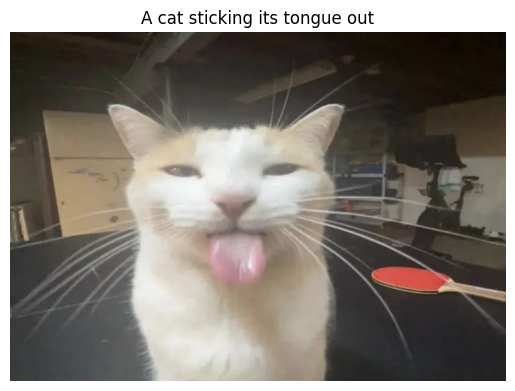

Original image shape: (518, 736, 3)
Final input shape: torch.Size([1, 3, 224, 224])
Input range: [-1.948, 2.535]
Input mean: -0.249

🔍 Prediction: DOG
🎯 Confidence: 50.10%
📊 Output logits: tensor([[0.4980, 0.5020]])
📈 Probabilities: tensor([[0.4990, 0.5010]])
❌ It is a dog! (This might be wrong)


In [ ]:
import numpy as np
import cv2
from urllib.request import urlopen
import matplotlib.pyplot as plt
from torchvision import transforms
import torch
from PIL import Image

img_url = "https://i.pinimg.com/736x/b6/83/78/b683788bf174e73ec3281c0f33cfecce.jpg"

resp = urlopen(img_url)
image = np.asarray(bytearray(resp.read()), dtype="uint8")
image = cv2.imdecode(image, cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.axis('off')
plt.title('A cat sticking its tongue out')
plt.show()

print(f"Original image shape: {image.shape}")

# Use the EXACT SAME pipeline as your training
preprocess = transforms.Compose([
    transforms.ToPILImage(),  # Convert to PIL
    transforms.Resize((224, 224)),  # Resize to match training
    transforms.ToTensor(),  # This converts to [0,1] range and (C,H,W)
    # NO additional /255.0 needed - ToTensor() already does this
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

def preprocess_image(image):
    # Use the exact same preprocessing as your training
    tensor = preprocess(image)
    return tensor.unsqueeze(0)

# Preprocess the image
input_tensor = preprocess_image(image)

print(f"Final input shape: {input_tensor.shape}")
print(f"Input range: [{input_tensor.min():.3f}, {input_tensor.max():.3f}]")
print(f"Input mean: {input_tensor.mean():.3f}")


with torch.no_grad():
    output = model(input_tensor)
    probabilities = torch.softmax(output, dim=1)
    
prediction = torch.argmax(output).item()
confidence = probabilities[0][prediction].item() * 100

print(f"\n🔍 Prediction: {'CAT' if prediction == 0 else 'DOG'}")
print(f"🎯 Confidence: {confidence:.2f}%")
print(f"📊 Output logits: {output}")
print(f"📈 Probabilities: {probabilities}")

if prediction == 0:
    print("✅ It is a cat!")
else:
    print("❌ It is a dog! (This might be wrong)")